In [1]:
!pip install torchview
!pip install opencv-python
!pip install graphviz

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 11.9 MB/s eta 0:00:0000:0100:01


In [2]:
import os
import sys
from pathlib import Path

path = Path(os.path.dirname(os.getcwd()))
path = str(path)
print(path)
sys.path.insert(1, path)

/Users/saideepbunny/Coursework/PRCV/MNIST-Recognition-using-Deep-Networks


In [ ]:
from greek_network_extension1 import GreekNetwork

def load_model(ModelNetwork, model_weights_path, set_to_eval):
    """
    Loads a trained PyTorch model from the given path.

    Args:
        model_weights_path (str): Path to the saved model weights (.pth file).
        set_to_eval (bool): Whether to set the model to evaluation mode.

    Returns:
        nn.Module: The loaded PyTorch model.
    """
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
    
    # Load the model
    network = ModelNetwork()
    network.load_state_dict(torch.load(model_weights_path))
    network.to(device)

    if(set_to_eval):
        network.eval()
    return network

model = GreekNetwork()
model = model.load_state_dict(torch.load(f"{path}/models/greek_model.pth"))
model

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

# Visualize the model with torchview
model_graph = draw_graph(
    model,
    input_size=(1, 1, 28, 28),  # batch_size=1, channels=1, height=28, width=28
    expand_nested=True,
    save_graph=True,
    directory=f"{path}/src",            # optional directory to save
    filename="greek_model_torchview"
)

# To display inside notebook (optional if using Jupyter)
model_graph.visual_graph

In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root=f"{path}/data",
    train=True,
    download=True,
    transform=ToTensor(),
)
training_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/saideepbunny/Coursework/PRCV/MNIST-Recognition-using-Deep-Networks/data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
# Download test data from open datasets.
test_data = datasets.MNIST(
    root=f"{path}/data",
    train=False,
    download=True,
    transform=ToTensor(),
)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /Users/saideepbunny/Coursework/PRCV/MNIST-Recognition-using-Deep-Networks/data
    Split: Test
    StandardTransform
Transform: ToTensor()

## 1A

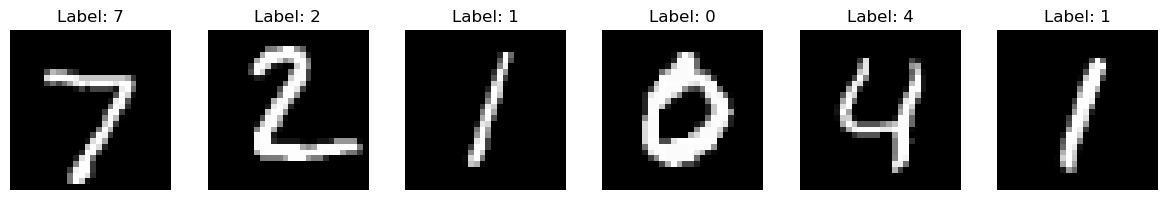

In [5]:
# Plot the first 6 images
fig, axes = plt.subplots(1, 6, figsize=(12, 2))  # 1 row, 6 columns

for i in range(6):
    img, label = test_data[i]
    axes[i].imshow(img.squeeze(), cmap="gray")  # Remove channel dimension
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")  # Hide axis ticks

plt.tight_layout()
plt.show()

## 1B

In [6]:
# Define the custom CNN network
class MyNetwork(nn.Module):
    def __init__(self):
        """
        Initializes the layers of the convolutional neural network.
        Architecture:
        - Conv1: 10 filters of size 5x5
        - MaxPool + ReLU
        - Conv2: 20 filters of size 5x5
        - Dropout
        - MaxPool + ReLU
        - Fully connected with 50 neurons + ReLU
        - Output layer with 10 neurons + log_softmax
        """
        super(MyNetwork, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.dropout = nn.Dropout(p=0.2) 
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        """
        Performs a forward pass through the network
        """
        x = self.pool1(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        x = self.pool2(F.relu(self.dropout(self.conv2(x))))  # Conv2 -> Dropout -> ReLU -> MaxPool
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))  # Fully connected layer + ReLU
        x = F.log_softmax(self.fc2(x), dim=1)  # Output layer with log_softmax
        return x


In [7]:
import matplotlib.pyplot as plt

def evaluate(model, data_loader, device, criterion):
    """Helper function to evaluate model loss and accuracy"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    avg_loss = total_loss / len(data_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy


def train_network(model, train_data, test_data, device, epochs=5, batch_size=64, learning_rate=0.01):
    """
    Trains the model and plots train/test loss and accuracy after each epoch.
    """
    model.to(device)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    criterion = nn.NLLLoss()

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

        # Training stats
        train_loss = total_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Evaluation on test set
        test_loss, test_acc = evaluate(model, test_loader, device, criterion)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, Test Loss={test_loss:.4f}, Test Acc={test_acc:.2f}%")

    # Plot Loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Testing Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training vs Testing Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


## 1C

Epoch 1: Train Loss=0.3741, Train Acc=87.51%, Test Loss=0.0828, Test Acc=97.38%
Epoch 2: Train Loss=0.0827, Train Acc=97.39%, Test Loss=0.0519, Test Acc=98.34%
Epoch 3: Train Loss=0.0613, Train Acc=98.06%, Test Loss=0.0435, Test Acc=98.57%
Epoch 4: Train Loss=0.0493, Train Acc=98.47%, Test Loss=0.0390, Test Acc=98.67%
Epoch 5: Train Loss=0.0417, Train Acc=98.66%, Test Loss=0.0417, Test Acc=98.65%
Epoch 6: Train Loss=0.0365, Train Acc=98.84%, Test Loss=0.0294, Test Acc=99.03%
Epoch 7: Train Loss=0.0339, Train Acc=98.96%, Test Loss=0.0312, Test Acc=98.94%
Epoch 8: Train Loss=0.0302, Train Acc=99.02%, Test Loss=0.0320, Test Acc=98.96%
Epoch 9: Train Loss=0.0277, Train Acc=99.14%, Test Loss=0.0273, Test Acc=99.13%
Epoch 10: Train Loss=0.0249, Train Acc=99.20%, Test Loss=0.0273, Test Acc=99.10%


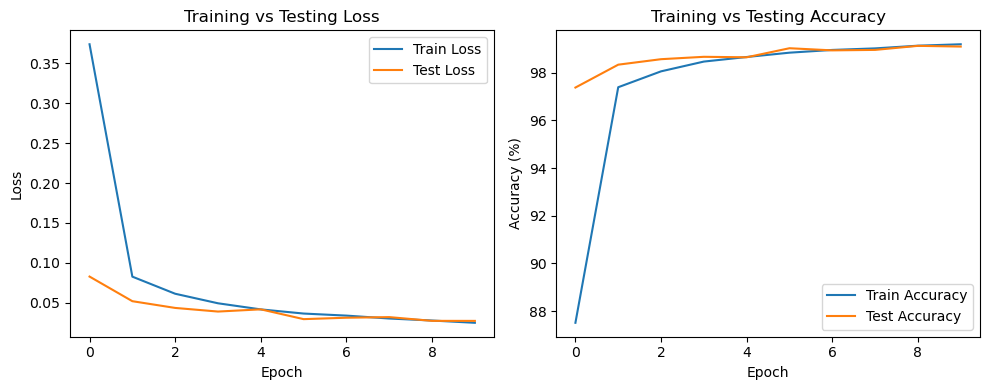

In [8]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model = MyNetwork()
train_network(model, training_data, test_data, device, epochs=10)


## 1D

In [9]:
torch.save(model.state_dict(), f"{path}/models/mnist_e10_model.pth")

## 1E

In [10]:
network = MyNetwork()                      # Recreate the same model architecture
network.load_state_dict(torch.load(f"{path}/models/mnist_e10_model.pth"))
network.to(device)
network.eval()                             # Set to evaluation mode if needed


MyNetwork(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

Image 1:
  Output values: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00']
  Predicted: 7, True Label: 7

Image 2:
  Output values: ['0.00', '0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
  Predicted: 2, True Label: 2

Image 3:
  Output values: ['0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
  Predicted: 1, True Label: 1

Image 4:
  Output values: ['1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
  Predicted: 0, True Label: 0

Image 5:
  Output values: ['0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00']
  Predicted: 4, True Label: 4

Image 6:
  Output values: ['0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
  Predicted: 1, True Label: 1

Image 7:
  Output values: ['0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00']
  Predicted: 4, True Label: 4

Image 8:
  Output values: ['0.00',

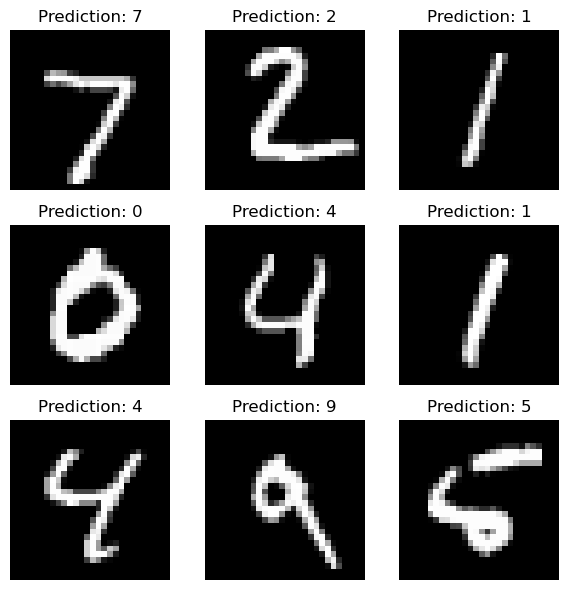

In [11]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np


# --- Load test data from existing path ---
transform = transforms.ToTensor()
test_data = datasets.MNIST(root=f"{path}/data", train=False, download=False, transform=transform)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)


# --- Get first 10 test samples ---
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = network(images)

# --- Process and Print Output ---
for i in range(10):
    output = outputs[i]
    probs = torch.exp(output)  # Convert from log_softmax to probabilities
    values = [f"{v:.2f}" for v in probs.tolist()]
    predicted = output.argmax().item()
    true_label = labels[i].item()
    
    print(f"Image {i+1}:")
    print(f"  Output values: {values}")
    print(f"  Predicted: {predicted}, True Label: {true_label}\n")

# --- Plot first 9 images in a 3x3 grid with predictions ---
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')
    pred = outputs[i].argmax().item()
    ax.set_title(f"Prediction: {pred}")
    ax.axis('off')

plt.tight_layout()
plt.show()


## 1F

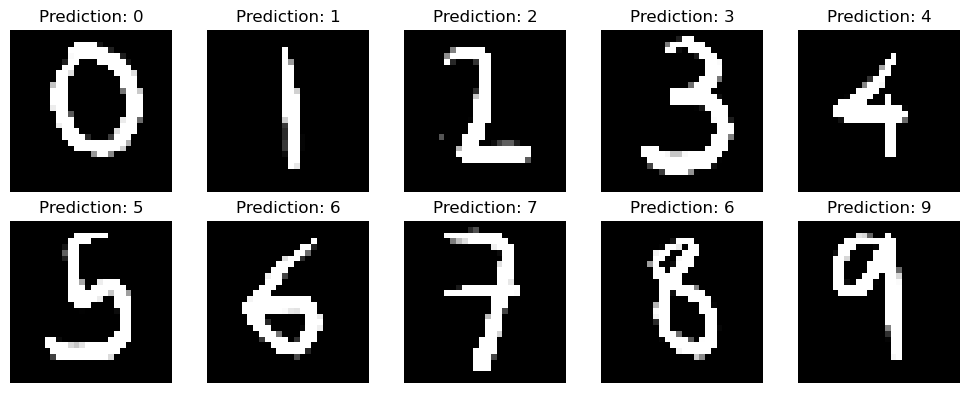

In [12]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np


# --- Define preprocessing ---
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),                # Ensure grayscale
    transforms.Resize((28, 28)),           # Resize to 28x28
    transforms.ToTensor(),                 # Convert to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Match MNIST normalization
])

# --- Load handwritten images ---
image_dir = f"{path}/images"
image_files = sorted(os.listdir(image_dir))  # Ensure they're in order: 0.png, 1.png, ...
custom_images = []
labels = []

for file in image_files:
    img_path = os.path.join(image_dir, file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read grayscale
    img = cv2.bitwise_not(img)                    # Invert: MNIST is white-on-black
    img = cv2.resize(img, (28, 28))               # Resize if needed
    tensor_img = transform(img)                   # Apply same MNIST transforms
    custom_images.append(tensor_img.unsqueeze(0))  # Add batch dimension
    labels.append(file.split('.')[0])             # Use file name as label (optional)

# --- Run through model and plot ---
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    img = custom_images[i].to(device)
    with torch.no_grad():
        output = network(img)
        pred = output.argmax(dim=1).item()
    
    ax.imshow(custom_images[i].squeeze().cpu(), cmap="gray")
    ax.set_title(f"Prediction: {pred}")
    ax.axis("off")

plt.tight_layout()
plt.show()


## 2A

conv1.weight shape: torch.Size([10, 1, 5, 5])


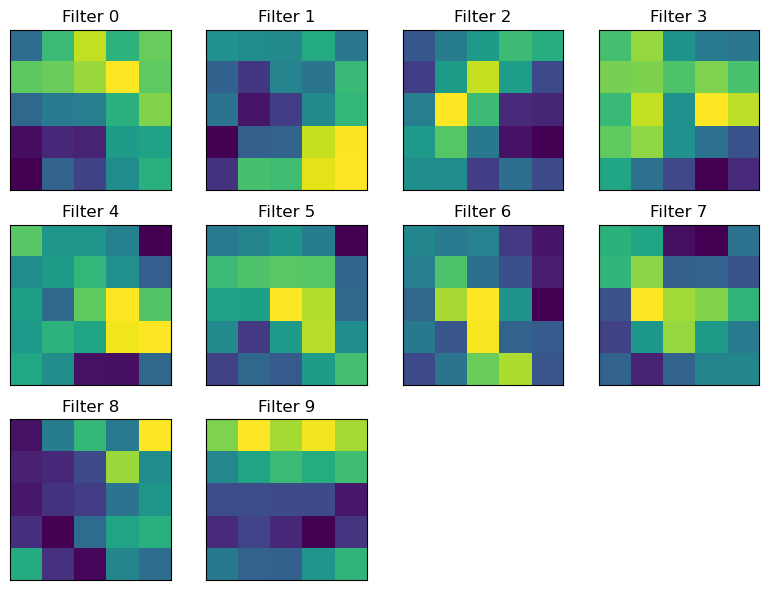

In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Load model
network = MyNetwork()                      # Recreate the same model architecture
network.load_state_dict(torch.load(f"{path}/models/mnist_e10_model.pth"))
network.to(device)
network.eval()                             # Set to evaluation mode if needed


# Get first layer weights
weights = network.conv1.weight.data  # Shape: [10, 1, 5, 5]
print("conv1.weight shape:", weights.shape)

# Plot 10 filters
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
for i, ax in enumerate(axes.flat[:10]):
    kernel = weights[i, 0].cpu().numpy()  # Get 5x5 filter of ith kernel
    ax.imshow(kernel, cmap='viridis')
    ax.set_title(f"Filter {i}")
    ax.set_xticks([])
    ax.set_yticks([])

# Hide any extra subplots (3x4 = 12 total)
for j in range(10, 12):
    axes.flat[j].axis("off")

plt.tight_layout()
plt.show()


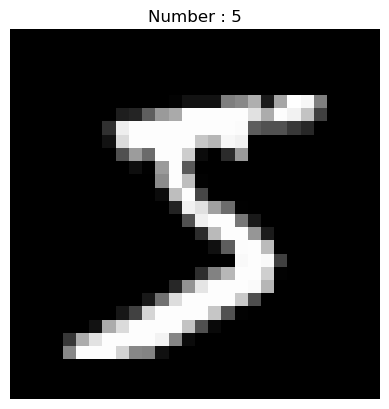

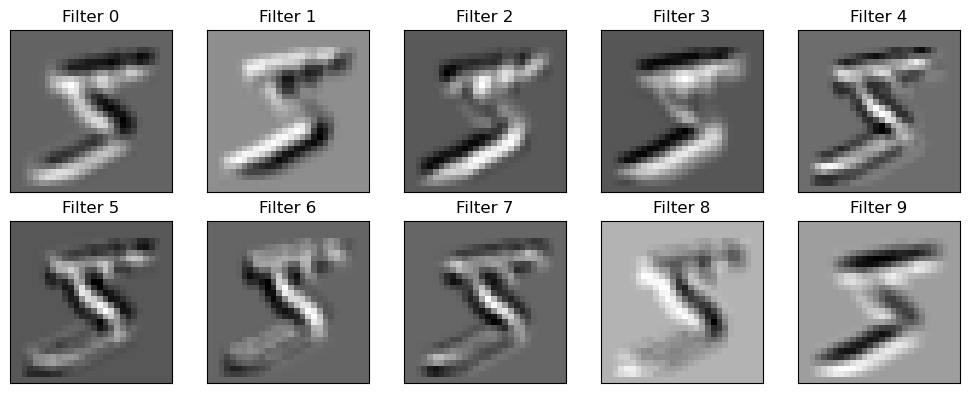

In [14]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import cv2
import numpy as np


# ----- Load first training image -----
transform = transforms.ToTensor()
train_data = datasets.MNIST(root=f"{path}/data", train=True, download=False, transform=transform)
first_img, label = train_data[0]  # First image
img_np = first_img.squeeze().numpy()  # Shape: (28, 28)

# ----- Get filters from conv1 -----
with torch.no_grad():
    filters = model.conv1.weight.data.cpu().numpy()  # Shape: [10, 1, 5, 5]


plt.imshow(img_np, cmap='gray')
plt.title(f"Number : {label}")
plt.axis('off')
plt.show()

# ----- Apply filters using OpenCV -----
filtered_images = []
for i in range(10):
    kernel = filters[i, 0]  # 5x5 kernel
    filtered = cv2.filter2D(img_np, -1, kernel)
    filtered_images.append(filtered)

# ----- Plot the 10 filtered outputs -----
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(filtered_images[i], cmap='gray')
    ax.set_title(f"Filter {i}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [15]:
network = MyNetwork()                      # Recreate the same model architecture
network.load_state_dict(torch.load(f"{path}/models/mnist_e10_model.pth"))

for param in network.parameters():
    param.requires_grad = False

network.fc2 = nn.Linear(50, 3)  # Replace with new head


In [16]:
class GreekTransform:
    def __init__(self):
        pass

    def __call__(self, x):
        x = transforms.functional.rgb_to_grayscale(x)
        x = transforms.functional.affine(x, angle=0, translate=(0, 0), scale=36/128, shear=0)
        x = transforms.functional.center_crop(x, (28, 28))
        return transforms.functional.invert(x)


In [17]:
from torchvision.datasets import ImageFolder

# Path to your greek_train directory
greek_path = f"{path}/data/Greek"

# Compose the full transform
transform = transforms.Compose([
    transforms.ToTensor(),
    GreekTransform(),
    transforms.Normalize((0.1307,), (0.3081,))  # match MNIST
])

# Load dataset using ImageFolder
greek_train = DataLoader(
    ImageFolder(f"{greek_path}/greek_train", transform=transform),
    batch_size=5,
    shuffle=True
)

greek_test = DataLoader(
    ImageFolder(f"{greek_path}/greek_test", transform=transform),
    batch_size=5,
    shuffle=True
)

In [18]:
print(len(greek_train.dataset))  # should be 27
print(len(greek_test.dataset))   # should be 15


27
15


In [19]:
import torch.optim as optim
import torch.nn.functional as F

optimizer = optim.SGD(network.fc2.parameters(), lr=0.0001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

for epoch in range(15):
    network.train()
    total_loss = 0
    correct = 0
    total = 0

    for data, target in greek_train:
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

    train_acc = 100. * correct / total

    # --- Evaluate on test set ---
    network.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data, target in greek_test:
            output = network(data)
            loss = criterion(output, target)

            test_loss += loss.item()
            pred = output.argmax(dim=1)
            test_correct += (pred == target).sum().item()
            test_total += target.size(0)

    test_acc = 100. * test_correct / test_total
    test_loss_avg = test_loss / len(greek_test)

    print(f"Epoch {epoch+1}")
    print(f"  Train Loss: {total_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"  Test  Loss: {test_loss_avg:.4f}, Test  Accuracy: {test_acc:.2f}%\n")


Epoch 1
  Train Loss: 6.6269, Train Accuracy: 62.96%
  Test  Loss: 2.0238, Test  Accuracy: 26.67%

Epoch 2
  Train Loss: 6.7297, Train Accuracy: 62.96%
  Test  Loss: 1.9445, Test  Accuracy: 26.67%

Epoch 3
  Train Loss: 5.8792, Train Accuracy: 62.96%
  Test  Loss: 1.8885, Test  Accuracy: 26.67%

Epoch 4
  Train Loss: 5.3940, Train Accuracy: 62.96%
  Test  Loss: 1.8457, Test  Accuracy: 33.33%

Epoch 5
  Train Loss: 4.6054, Train Accuracy: 70.37%
  Test  Loss: 1.8140, Test  Accuracy: 33.33%

Epoch 6
  Train Loss: 4.4912, Train Accuracy: 70.37%
  Test  Loss: 1.8007, Test  Accuracy: 33.33%

Epoch 7
  Train Loss: 3.7542, Train Accuracy: 74.07%
  Test  Loss: 1.7734, Test  Accuracy: 33.33%

Epoch 8
  Train Loss: 3.3910, Train Accuracy: 81.48%
  Test  Loss: 1.7511, Test  Accuracy: 33.33%

Epoch 9
  Train Loss: 3.1624, Train Accuracy: 85.19%
  Test  Loss: 1.7455, Test  Accuracy: 33.33%

Epoch 10
  Train Loss: 2.7578, Train Accuracy: 88.89%
  Test  Loss: 1.7436, Test  Accuracy: 33.33%

Epoch 11


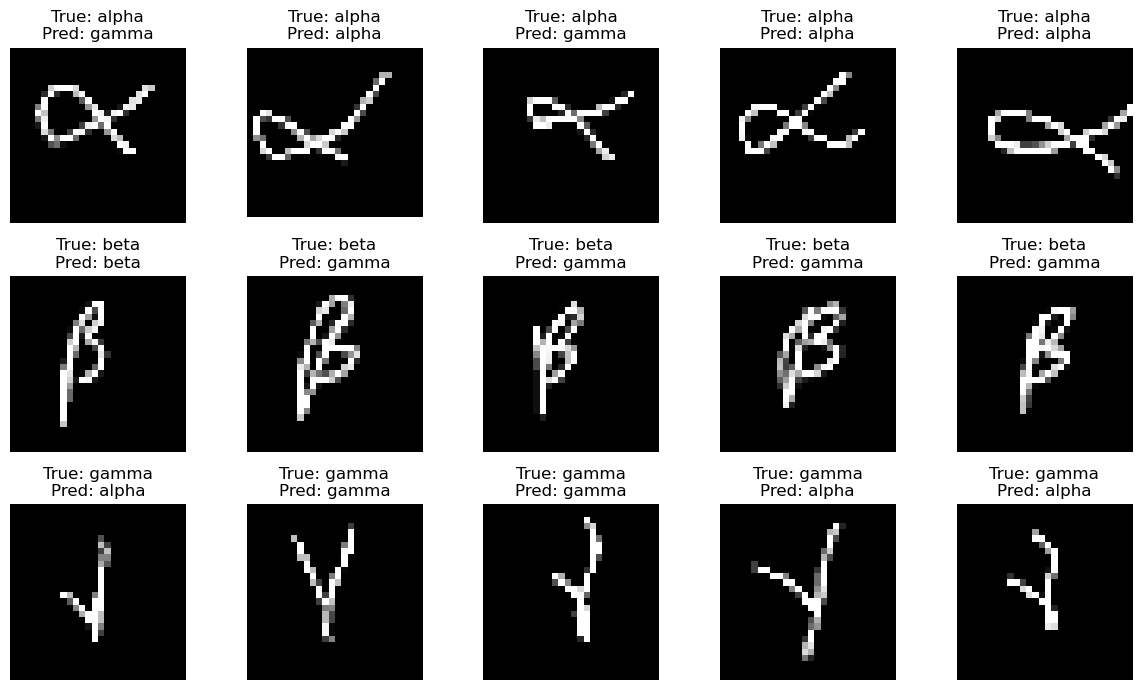

In [20]:
# Load entire dataset in order, no shuffling
greek_test_all = DataLoader(
    ImageFolder(f"{greek_path}/greek_test", transform=transform),
    batch_size=1,
    shuffle=False
)

# Class names from folder names
class_names = greek_test_all.dataset.classes  # ['alpha', 'beta', 'gamma']

# Collect all predictions
images_list = []
labels_list = []
preds_list = []

network.eval()
with torch.no_grad():
    for img, label in greek_test_all:
        output = network(img)
        pred = output.argmax(dim=1)

        images_list.append(img.squeeze(0))  # Remove batch dimension
        labels_list.append(label.item())
        preds_list.append(pred.item())

# Plot all 15 images in a 3x5 grid
fig, axes = plt.subplots(3, 5, figsize=(12, 7))
for i, ax in enumerate(axes.flat):
    img = images_list[i].squeeze().numpy()
    true_label = class_names[labels_list[i]]
    pred_label = class_names[preds_list[i]]

    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import pandas as pd
from itertools import product
import random

# Set device
device = torch.device("mps" if torch.mps.is_available() else "cpu")

# Load FashionMNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data = datasets.FashionMNIST(root=f'{path}/data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root=f'{path}/data', train=False, download=True, transform=transform)

# Flexible CNN
class FlexibleCNN(nn.Module):
    def __init__(self, conv_layers, linear_layers, dropout_rate, hidden_units):
        super().__init__()
        self.activation = F.relu
        self.convs = nn.Sequential()
        in_channels = 1
        H, W = 28, 28

        for i in range(conv_layers):
            out_channels = 16 * (i + 1)
            self.convs.add_module(f'conv{i}', nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            self.convs.add_module(f'relu{i}', nn.ReLU())
            if H >= 2 and W >= 2:
                self.convs.add_module(f'pool{i}', nn.MaxPool2d(2))
                H, W = H // 2, W // 2
            in_channels = out_channels

        dummy = torch.zeros(1, 1, 28, 28)
        with torch.no_grad():
            x = self.convs(dummy)
            self.flat_dim = x.view(1, -1).size(1)

        self.dropout = nn.Dropout(dropout_rate)
        self.linear_layers = nn.Sequential()

        if linear_layers == 1:
            self.linear_layers.add_module("fc1", nn.Linear(self.flat_dim, hidden_units))
        elif linear_layers == 2:
            self.linear_layers.add_module("fc1", nn.Linear(self.flat_dim, hidden_units))
            self.linear_layers.add_module("relu1", nn.ReLU())
            self.linear_layers.add_module("fc2", nn.Linear(hidden_units, hidden_units))

        self.final_layer = nn.Linear(hidden_units, 10)

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear_layers(x)
        x = self.activation(x)
        return F.log_softmax(self.final_layer(x), dim=1)



from itertools import product

conv_layers_list = [2, 3, 4, 5]
linear_layers_list = [1, 2]
dropouts = [0.1, 0.3, 0.5]
hidden_units_list = [64, 128]
batch_sizes = [32, 64]

grid = list(product(conv_layers_list, linear_layers_list, dropouts, hidden_units_list, batch_sizes))
random.shuffle(grid)
grid = grid[:30]  # Sample 30 combinations

results = []

def train_and_evaluate(config):
    conv_layers, linear_layers, dropout_rate, hidden_units, batch_size = config
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=64)

    model = FlexibleCNN(conv_layers, linear_layers, dropout_rate, hidden_units).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.NLLLoss()

    start_time = time.time()
    model.train()
    for epoch in range(3):
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()
    duration = time.time() - start_time

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    acc = 100 * correct / total
    return {
        'conv_layers': conv_layers,
        'linear_layers': linear_layers,
        'dropout_rate': dropout_rate,
        'hidden_units': hidden_units,
        'batch_size': batch_size,
        'test_acc': acc,
        'time_sec': round(duration, 2)
    }

# Run experiments
for config in grid:
    print("Running config:", config)
    results.append(train_and_evaluate(config))

# Save to CSV
df = pd.DataFrame(results)
df.sort_values(by='test_acc', ascending=False)



Running config: (2, 1, 0.1, 128, 64)
Running config: (5, 2, 0.1, 64, 32)
Running config: (5, 1, 0.1, 128, 64)
Running config: (2, 2, 0.1, 64, 64)
Running config: (4, 1, 0.3, 64, 32)
Running config: (2, 2, 0.3, 64, 64)
Running config: (3, 1, 0.5, 64, 64)
Running config: (3, 1, 0.1, 128, 64)
Running config: (5, 1, 0.5, 128, 64)
Running config: (3, 1, 0.5, 64, 32)
Running config: (2, 2, 0.3, 64, 32)
Running config: (2, 2, 0.5, 128, 32)
Running config: (4, 2, 0.3, 64, 32)
Running config: (4, 1, 0.5, 64, 64)
Running config: (3, 2, 0.1, 64, 32)
Running config: (2, 1, 0.5, 128, 64)
Running config: (5, 1, 0.5, 64, 32)
Running config: (2, 1, 0.3, 128, 64)
Running config: (4, 2, 0.3, 128, 32)
Running config: (5, 2, 0.5, 64, 64)
Running config: (2, 1, 0.5, 128, 32)
Running config: (2, 2, 0.3, 128, 64)
Running config: (4, 1, 0.5, 128, 64)
Running config: (5, 2, 0.3, 128, 64)
Running config: (4, 1, 0.5, 128, 32)
Running config: (3, 2, 0.1, 64, 64)
Running config: (5, 1, 0.3, 128, 64)
Running config

,conv_layers,linear_layers,dropout_rate,hidden_units,batch_size,test_acc,time_sec
28,3,1,0.1,128,32,90.16,37.00
21,2,2,0.3,128,64,90.04,22.14
20,2,1,0.5,128,32,89.91,33.24
17,2,1,0.3,128,64,89.73,20.58
14,3,2,0.1,64,32,89.70,41.04
11,2,2,0.5,128,32,89.50,38.23
0,2,1,0.1,128,64,89.49,23.09
7,3,1,0.1,128,64,89.39,23.54
10,2,2,0.3,64,32,89.25,36.09
15,2,1,0.5,128,64,89.25,24.13


In [1]:
import cv2

help(cv2.resize)

Help on built-in function resize:

resize(...)
    resize(src, dsize[, dst[, fx[, fy[, interpolation]]]]) -> dst
    .   @brief Resizes an image.
    .
    .   The function resize resizes the image src down to or up to the specified size. Note that the
    .   initial dst type or size are not taken into account. Instead, the size and type are derived from
    .   the `src`,`dsize`,`fx`, and `fy`. If you want to resize src so that it fits the pre-created dst,
    .   you may call the function as follows:
    .   @code
    .       // explicitly specify dsize=dst.size(); fx and fy will be computed from that.
    .       resize(src, dst, dst.size(), 0, 0, interpolation);
    .   @endcode
    .   If you want to decimate the image by factor of 2 in each direction, you can call the function this
    .   way:
    .   @code
    .       // specify fx and fy and let the function compute the destination image size.
    .       resize(src, dst, Size(), 0.5, 0.5, interpolation);
    .   @endcode
   